Reads from segmentation metadata and generates object detection labels

In [1]:
import sys ,os, importlib
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

import configparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from importlib import reload
from tqdm import tqdm
tqdm.pandas()
import plotly.express as px
import bbox_utils as BboxUtils
import utils as Utils
import dl_utils as DL

reload(DL)
reload(BboxUtils)
reload(Utils)
config = configparser.ConfigParser()
config.read("../config.ini")

['../config.ini']

In [2]:
PROCESSED_DATA_PATH = config["PATHS"]["PROCESSED_DATA_PATH"]
METADATA_PATH = os.path.join(PROCESSED_DATA_PATH, "segmentation", "metadata.csv")
print(PROCESSED_DATA_PATH)
print(METADATA_PATH)

/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/segmentation/metadata.csv


In [3]:
processed_metadata_df = pd.read_csv(METADATA_PATH, delimiter=";", header=0, dtype= Utils.SCHEMA_METADATA_DF)
# removing erroneously inserted headers
processed_metadata_df = processed_metadata_df[processed_metadata_df["dataset"]!="dataset"]
print(processed_metadata_df.shape)
print(processed_metadata_df.dtypes)
processed_metadata_df.head(2)

(87799, 11)
dataset                string[python]
label                  string[python]
scan_index                      int64
slice_index                     int64
ct_slice_path          string[python]
infection_mask_path    string[python]
lung_mask_path         string[python]
height                          int64
width                           int64
has_infection                    bool
has_lung_mask                    bool
dtype: object


dataset  label  scan_index  slice_index  \
0  COVID_SEG_1  covid           0            0   
1  COVID_SEG_1  covid           1            1   

                                       ct_slice_path  \
0  /media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19...   
1  /media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19...   

                                 infection_mask_path  \
0  /media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19...   
1  /media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19...   

                                      lung_mask_path  height  width  \
0  /media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19...     512    512   
1  /media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19...     512    512   

   has_infection  has_lung_mask  
0           True           True  
1           True           True

In [5]:
processed_metadata_df[["dataset"]].value_counts()

dataset        
MOSMED             46411
CNCB               21470
MIDRC_RICORD_1A    15887
COVID_CT_JunMa      3102
COVID_SEG_2          829
COVID_SEG_1          100
Name: count, dtype: int64

In [6]:
processed_metadata_df[["has_infection"]].value_counts()


has_infection
False            75886
True             11913
Name: count, dtype: int64

In [7]:
# group by dataset and has_infection
grouped_df = processed_metadata_df.groupby(["dataset", "has_infection"]).size().reset_index(name='counts')
grouped_df.head(100)

dataset  has_infection  counts
0              CNCB          False   20921
1              CNCB           True     549
2    COVID_CT_JunMa          False    1406
3    COVID_CT_JunMa           True    1696
4       COVID_SEG_1          False       4
5       COVID_SEG_1           True      96
6       COVID_SEG_2          False     456
7       COVID_SEG_2           True     373
8   MIDRC_RICORD_1A          False    7473
9   MIDRC_RICORD_1A           True    8414
10           MOSMED          False   45626
11           MOSMED           True     785

In [8]:
print(processed_metadata_df[["height"]].value_counts())
print(processed_metadata_df[["width"]].value_counts())

height
512       87799
Name: count, dtype: int64
width
512      87799
Name: count, dtype: int64


# Generate Object Detection Annotations

In [9]:
processed_metadata_df["original_bbox"] = processed_metadata_df.progress_apply(
lambda row: BboxUtils.get_bboxes_from_seg_row(row, "infection_mask_path") if row["has_infection"] == True and row["infection_mask_path"] != "" else None, axis=1)


  0%|          | 0/87799 [00:00<?, ?it/s]

100%|██████████| 87799/87799 [12:22<00:00, 118.30it/s]  


In [10]:
processed_metadata_df["num_original_bboxes"] = processed_metadata_df["original_bbox"].progress_apply(lambda x: len(x) if x is not None else 0)
processed_metadata_df["nms_bboxes_25"] = processed_metadata_df["original_bbox"].progress_apply(BboxUtils.non_max_suppression,overlapThresh=0.25)
processed_metadata_df["nms_bboxes_50"] = processed_metadata_df["original_bbox"].progress_apply(BboxUtils.non_max_suppression,overlapThresh=0.5)
processed_metadata_df["nms_bboxes_50_merged"] = processed_metadata_df["nms_bboxes_50"].progress_apply(BboxUtils.merge_overlapping_boxes, overlapThresh=1e-9)

# Call the function with your DataFrame and a list of epsilon values
epsilons = [0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001]
xis = [0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001]
df_with_hdbscan_clustering_1 = (
    BboxUtils
    .calculate_hdbscan_bboxes_and_iou(
        processed_metadata_df,min_cluster_size=2, min_samples=1, epsilons=epsilons, source_bbox_col_name="nms_bboxes_50",post_nms_iou_threshold=0.25, skip_iou_calculation=True, 
        )
)

# df_with_optics_clustering = BboxUtils.calculate_optics_bboxes_and_iou(df_with_hdbscan_clustering, xis, min_samples=2)

100%|██████████| 87799/87799 [00:00<00:00, 109572.16it/s]


In [11]:
df_with_hdbscan_clustering_2 = (
    BboxUtils
    .calculate_hdbscan_bboxes_and_iou(
        df_with_hdbscan_clustering_1,min_cluster_size=2, min_samples=1, epsilons=epsilons, source_bbox_col_name="nms_bboxes_50",post_nms_iou_threshold=0.5, use_sizes=True, column_sufix="with_sizes", skip_iou_calculation=True)
)

100%|██████████| 87799/87799 [00:00<00:00, 128904.69it/s]


In [12]:
df_with_hdbscan_clustering_3 = (
    BboxUtils
    .calculate_hdbscan_bboxes_and_iou(
        df_with_hdbscan_clustering_2,
        min_cluster_size=2,
        min_samples=1, 
        epsilons=epsilons,
        source_bbox_col_name= "nms_bboxes_50", 
        post_nms_iou_threshold=0.25, 
        use_sizes=True, 
        column_sufix="threshold_10", 
        skip_iou_calculation=True,
        n_boxes_threshold=10
        )
)

100%|██████████| 87799/87799 [00:00<00:00, 111447.72it/s]


84697


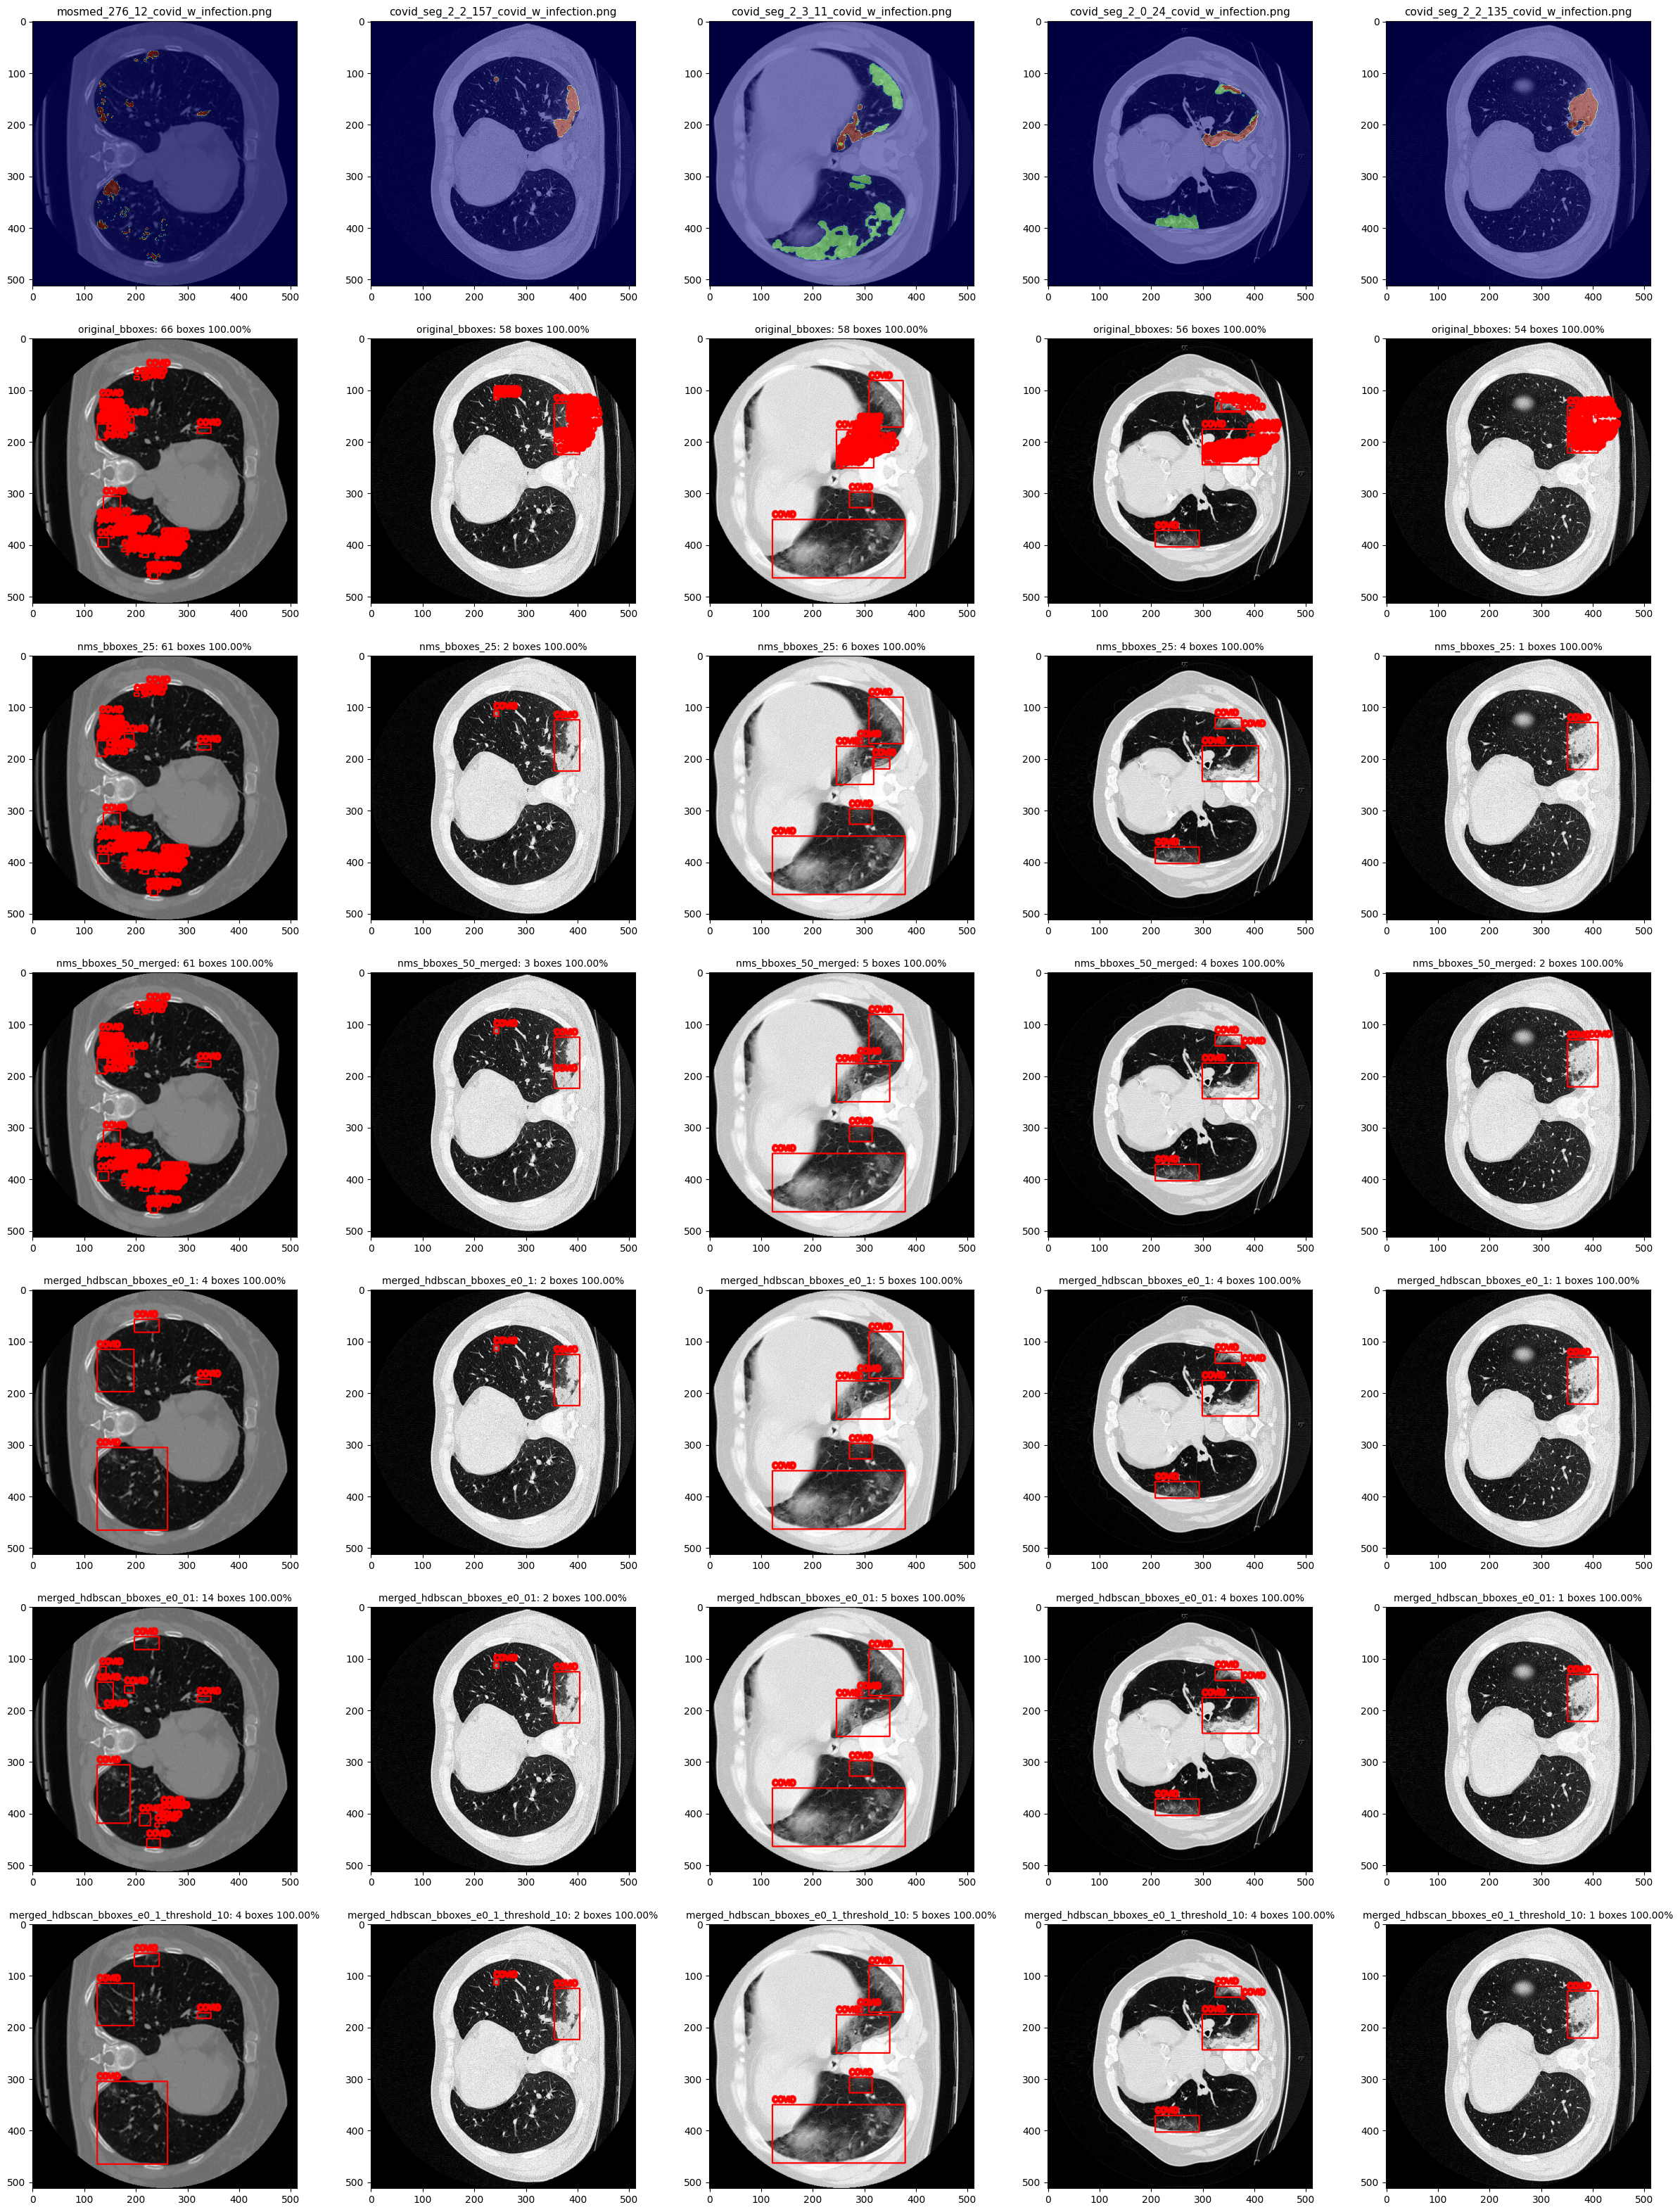

In [73]:
#Random take 10 filenames from dataset
ct_file_names = [
# "covid_seg_1_83_83_covid_w_infection.png",
# "mosmed_285_22_covid_w_infection.png",
# "midrc_ricord_1a_20_56_covid_w_infection.png",
# "cncb_93_23_covid_w_infection.png",
# "midrc_ricord_1a_52_107_covid_w_infection.png",
# "midrc_ricord_1a_83_33_covid_w_infection.png",
# "midrc_ricord_1a_5_57_covid_w_infection.png",
# "mosmed_293_36_covid_w_infection.png",
# "cncb_35_109_covid_w_infection.png",
# "covid_seg_2_2_169_covid_w_infection.png"
]

filtered_df = processed_metadata_df.copy()
filtered_df["filename"] = filtered_df["ct_slice_path"].apply(lambda x: x.split("/")[-1])
if len(ct_file_names) > 0:
    filtered_df = filtered_df[filtered_df["filename"].isin(ct_file_names)]
print(len(filtered_df))

BboxUtils.plot_object_detection_df(
    filtered_df,
    5,
    "original_bbox",
    "nms_bboxes_25",
    #"nms_bboxes_50",
    "nms_bboxes_50_merged",
    "merged_hdbscan_bboxes_e0_1",
    "merged_hdbscan_bboxes_e0_01",
    #"merged_hdbscan_bboxes_e0_001",
    #"merged_hdbscan_bboxes_e0_1_with_sizes",
    "merged_hdbscan_bboxes_e0_1_threshold_10",
    #"merged_hdbscan_bboxes_e0_01_threshold_10",
    samplimg_method=None,
    figsize=(30,40),
    print_overlap_percentage=True,
    save_dir="/media/my_ftp/TFTs/amoure/figs/object_det_dataset_p1.png"
)


In [15]:
processed_metadata_df = df_with_hdbscan_clustering_3.copy()
print(processed_metadata_df.shape)
print(processed_metadata_df.columns)

(87799, 43)
Index(['dataset', 'label', 'scan_index', 'slice_index', 'ct_slice_path',
       'infection_mask_path', 'lung_mask_path', 'height', 'width',
       'has_infection', 'has_lung_mask', 'original_bbox',
       'num_original_bboxes', 'nms_bboxes_25', 'nms_bboxes_50',
       'nms_bboxes_50_merged', 'merged_hdbscan_bboxes_e0_7',
       'merged_hdbscan_bboxes_e0_5', 'merged_hdbscan_bboxes_e0_3',
       'merged_hdbscan_bboxes_e0_2', 'merged_hdbscan_bboxes_e0_1',
       'merged_hdbscan_bboxes_e0_05', 'merged_hdbscan_bboxes_e0_01',
       'merged_hdbscan_bboxes_e0_001', 'merged_hdbscan_bboxes_e0_0001',
       'merged_hdbscan_bboxes_e0_7_with_sizes',
       'merged_hdbscan_bboxes_e0_5_with_sizes',
       'merged_hdbscan_bboxes_e0_3_with_sizes',
       'merged_hdbscan_bboxes_e0_2_with_sizes',
       'merged_hdbscan_bboxes_e0_1_with_sizes',
       'merged_hdbscan_bboxes_e0_05_with_sizes',
       'merged_hdbscan_bboxes_e0_01_with_sizes',
       'merged_hdbscan_bboxes_e0_001_with_sizes',
  

# Dataset Split

## Train/Test and 5-fold cross validation

In [19]:
processed_metadata_df = DL.balanced_split_dataframe(processed_metadata_df, test_size=0.2, random_state=42, stratify_columns=["has_infection", "dataset"])
train_df = processed_metadata_df[processed_metadata_df["split"] == "train"].copy()
val_df = processed_metadata_df[processed_metadata_df["split"] == "test"].copy()
print(train_df.shape)
print(train_df["has_infection"].value_counts())
print(val_df.shape)
print(val_df["has_infection"].value_counts())
print(f"Total size: {processed_metadata_df.shape[0]}")
print(f"Sum of train and test: {train_df.shape[0] + val_df.shape[0]}")

(70239, 45)
has_infection
False    60709
True      9530
Name: count, dtype: int64
(17560, 45)
has_infection
False    15177
True      2383
Name: count, dtype: int64
Total size: 87799
Sum of train and test: 87799


In [21]:
processed_metadata_df = DL.kfold_split_dataframe(processed_metadata_df, n_splits=5, random_state=42,stratify_columns=["has_infection"])

In [16]:
# Freeze dataframe so splits remain the same 
processed_metadata_df.to_pickle(os.path.join(PROCESSED_DATA_PATH, "object_detection", "metadata_with_bboxes.pkl"))

# Start Here 

Read the saved df and perform calculations

In [3]:
processed_metadata_df = pd.read_pickle(os.path.join(PROCESSED_DATA_PATH, "object_detection", "metadata_with_bboxes.pkl"))
## New: Leave COVID_CT_JUNMA out as an independant testing dataset
processed_metadata_df = processed_metadata_df[processed_metadata_df["dataset"]!='COVID_CT_JunMa']
print(processed_metadata_df.shape)
print(processed_metadata_df.groupby(["split"]).size())

(84697, 81)
split
test     16940
train    67757
dtype: int64


## Post generation sanity checks

In [8]:
for bbox_col_name in [
    'original_bbox',
    'nms_bboxes_25',
    'nms_bboxes_50',
    'nms_bboxes_50_merged',
    'merged_hdbscan_bboxes_e0_7',
    'merged_hdbscan_bboxes_e0_5',
    'merged_hdbscan_bboxes_e0_3',
    'merged_hdbscan_bboxes_e0_2',
    'merged_hdbscan_bboxes_e0_1',
    'merged_hdbscan_bboxes_e0_05',
    'merged_hdbscan_bboxes_e0_01',
    'merged_hdbscan_bboxes_e0_001',
    'merged_hdbscan_bboxes_e0_0001',
    'merged_hdbscan_bboxes_e0_7_with_sizes',
    'merged_hdbscan_bboxes_e0_5_with_sizes',
    'merged_hdbscan_bboxes_e0_3_with_sizes',
    'merged_hdbscan_bboxes_e0_2_with_sizes',
    'merged_hdbscan_bboxes_e0_1_with_sizes',
    'merged_hdbscan_bboxes_e0_05_with_sizes',
    'merged_hdbscan_bboxes_e0_01_with_sizes',
    'merged_hdbscan_bboxes_e0_001_with_sizes',
    'merged_hdbscan_bboxes_e0_0001_with_sizes',
    'merged_hdbscan_bboxes_e0_7_threshold_10',
    'merged_hdbscan_bboxes_e0_5_threshold_10',
    'merged_hdbscan_bboxes_e0_3_threshold_10',
    'merged_hdbscan_bboxes_e0_2_threshold_10',
    'merged_hdbscan_bboxes_e0_1_threshold_10',
    'merged_hdbscan_bboxes_e0_05_threshold_10',
    'merged_hdbscan_bboxes_e0_01_threshold_10',
    'merged_hdbscan_bboxes_e0_001_threshold_10',
    'merged_hdbscan_bboxes_e0_0001_threshold_10']:
    processed_metadata_df[f"%uncovered_mask_{bbox_col_name}"] = (
        processed_metadata_df[processed_metadata_df["has_infection"]==True].progress_apply(lambda row: BboxUtils.udf_mask_uncovered(row, "infection_mask_path", bbox_col_name, 5), axis=1)
    )
    print(f"%uncovered_mask_{bbox_col_name}: ", processed_metadata_df[f"%uncovered_mask_{bbox_col_name}"].sum()/len(processed_metadata_df[processed_metadata_df["has_infection"]==True])*100)




  0%|          | 18/10217 [00:01<12:17, 13.82it/s]

  1%|          | 62/10217 [00:04<12:36, 13.43it/s]


KeyboardInterrupt: 

## COCO Format

In [5]:
bounding_boxes_col_names = ["nms_bboxes_25", "merged_hdbscan_bboxes_e0_01", "merged_hdbscan_bboxes_e0_1_threshold_10"]
pd.set_option('display.max_colwidth', None)
processed_metadata_df[bounding_boxes_col_names].head()

nms_bboxes_25  \
68786                                                               None   
80033                                                               None   
4666   [[307, 127, 430, 374], [83, 282, 236, 405], [114, 136, 132, 157]]   
32491                                                               None   
32481                                                               None   

                                                                     merged_hdbscan_bboxes_e0_01  \
68786                                                                                       None   
80033                                                                                       None   
4666   [[307.0, 127.0, 430.0, 374.0], [83.0, 282.0, 236.0, 405.0], [114.0, 136.0, 132.0, 157.0]]   
32491                                                                                       None   
32481                                                                                       None   

                                 merged_hdbscan_bboxes_e0_1_threshold_10  
68786                                                               None  
80033                                                               None  
4666   [[307, 127, 430, 374], [83, 282, 236, 405], [114, 136, 132, 157]]  
32491                                                               None  
32481                                                               None

In [6]:
path_coco_annons = os.path.join(PROCESSED_DATA_PATH, "object_detection", "coco_annotations")
os.makedirs(path_coco_annons, exist_ok=True)
for bbox_col_name in bounding_boxes_col_names:
    print(f"Generating coco files for : {bbox_col_name}")
    os.makedirs(os.path.join(path_coco_annons, bbox_col_name), exist_ok=True)
    path_bbox_col_name = os.path.join(path_coco_annons, bbox_col_name)
    coco_train_annos_path = os.path.join(path_bbox_col_name, "coco_train.json")
    coco_val_annos_path = os.path.join(path_bbox_col_name, "coco_val.json")
    coco_train_annos = BboxUtils.create_coco_json(processed_metadata_df[processed_metadata_df["split"] == "train"], bboxes_col_name=bbox_col_name, has_bbox_col_name="has_infection",output_file=coco_train_annos_path, relative_path=True)
    coco_val_annos = BboxUtils.create_coco_json(processed_metadata_df[processed_metadata_df["split"] == "test"], bboxes_col_name=bbox_col_name, has_bbox_col_name="has_infection", output_file=coco_val_annos_path, relative_path=True)

Generating coco files for : nms_bboxes_25
Generating coco files for : merged_hdbscan_bboxes_e0_01
Generating coco files for : merged_hdbscan_bboxes_e0_1_threshold_10


### YOLO Format 
careful, it needs to copy all images to target folder!!

In [8]:
path_yolo_annos = os.path.join(PROCESSED_DATA_PATH, "object_detection", "yolo_annotations")
path_yolo_train_images = os.path.join(path_yolo_annos,"normal_images", "train")
path_yolo_val_images = os.path.join(path_yolo_annos, "normal_images", "val")
os.makedirs(path_yolo_train_images, exist_ok=True)
os.makedirs(path_yolo_val_images, exist_ok=True)

(processed_metadata_df[processed_metadata_df["split"]=="train"]["ct_slice_path"]
 .progress_apply(
     lambda path:
       Utils.copy_image_to_folder(path, os.path.join(path_yolo_train_images, path.split("/")[-1])))
)

(processed_metadata_df[processed_metadata_df["split"]=="test"]["ct_slice_path"]
 .progress_apply(
     lambda path: Utils.copy_image_to_folder(path, os.path.join(path_yolo_val_images, path.split("/")[-1])))
)

  0%|          | 2/67757 [00:00<1:06:48, 16.90it/s]

  1%|          | 702/67757 [01:36<2:34:22,  7.24it/s]


KeyboardInterrupt: 

In [ ]:
path_yolo_train_images = os.path.join(path_yolo_annos, "enhanced_images", "train")
path_yolo_val_images = os.path.join(path_yolo_annos, "enhanced_images", "val")

# We read from the enhanced folder (with hist eq and clahe) and copy to the yolo folder
(processed_metadata_df[processed_metadata_df["split"]=="train"]["ct_slice_path"]
 .progress_apply(
     lambda path:
       Utils.copy_image_to_folder(path.replace("rgb_images", "enhanced"),os.path.join(path_yolo_train_images, path.split("/")[-1])))
)

(processed_metadata_df[processed_metadata_df["split"]=="test"]["ct_slice_path"]
 .progress_apply(
     lambda path: Utils.copy_image_to_folder(path.replace("rgb_images", "enhanced"), os.path.join(path_yolo_val_images, path.split("/")[-1])))
)

In [ ]:
for bbox_col_name in bounding_boxes_col_names:
    path_bbox_col_name = os.path.join(path_coco_annons, bbox_col_name)
    coco_train_annos_path = os.path.join(path_bbox_col_name, "coco_train.json")
    coco_val_annos_path = os.path.join(path_bbox_col_name, "coco_val.json")
    path_yolo_train_annos = os.path.join(path_yolo_annos,f"labels_{bbox_col_name}", "train")
    path_yolo_val_annos = os.path.join(path_yolo_annos, f"labels_{bbox_col_name}","val",)
    # create all needed directories
    os.makedirs(path_yolo_train_annos, exist_ok=True)
    os.makedirs(path_yolo_val_annos, exist_ok=True)
    print(path_yolo_train_annos)
    print(path_yolo_val_annos)
    BboxUtils.convert_coco_to_yolo(coco_train_annos_path, path_yolo_train_annos, False)
    BboxUtils.convert_coco_to_yolo(coco_val_annos_path, path_yolo_val_annos, False)


/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/object_detection/yolo_annotations/labels_nms_bboxes_25/train
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/object_detection/yolo_annotations/labels_nms_bboxes_25/val


  0%|          | 0/27864 [00:00<?, ?it/s]

  0%|          | 0/6990 [00:00<?, ?it/s]

/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/object_detection/yolo_annotations/labels_merged_hdbscan_bboxes_e0_01/train
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/object_detection/yolo_annotations/labels_merged_hdbscan_bboxes_e0_01/val


  0%|          | 0/20768 [00:00<?, ?it/s]

  0%|          | 0/5207 [00:00<?, ?it/s]

/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/object_detection/yolo_annotations/labels_merged_hdbscan_bboxes_e0_1_threshold_10/train
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/object_detection/yolo_annotations/labels_merged_hdbscan_bboxes_e0_1_threshold_10/val


  0%|          | 0/24896 [00:00<?, ?it/s]

  0%|          | 0/6229 [00:00<?, ?it/s]

Copy normal images

Copy enhanced images

## 5 fold labels

In [ ]:
# # create coco JSON annotations for every fold and save them
# for split in tqdm(range(5)):
#     # select all rows that are in the current split using the splot_{fold} column
#     # empty Pandas df
#     split_train_df_list = []
#     split_val_df_list = []
#     for train_fold in range(5):
#         #iteratively add all other folds to the train set
#         if train_fold != split:
#             split_train_df_list.append(processed_metadata_df[processed_metadata_df[f"split_{train_fold}"] == "train"])
#         else:
#             split_val_df_list.append(processed_metadata_df[processed_metadata_df[f"split_{train_fold}"] == "test"])

#     split_train_df = pd.concat(split_train_df_list)
#     split_val_df = pd.concat(split_val_df_list)

#     split_coco_train_annos_path = os.path.join(path_coco_annons, f"coco_split{split}_train.json")
#     BboxUtils.create_coco_json(split_train_df, bboxes_col_name="nms_bboxes_25%", has_bbox_col_name="has_infection", output_file=split_coco_train_annos_path)
#     split_coco_val_annons_path = os.path.join(path_coco_annons, f"coco_split{split}_val.json")
#     BboxUtils.create_coco_json(split_val_df, bboxes_col_name="nms_bboxes_25%", has_bbox_col_name="has_infection", output_file=split_coco_val_annons_path)

    


100%|██████████| 5/5 [00:50<00:00, 10.12s/it]


# Semi-supervised dataframe

In [ ]:
# # create unlabeled coco .json
# CLASSIFICATION_PATH = os.path.join(PROCESSED_DATA_PATH, 'classification')

# normal_class_path = os.path.join(CLASSIFICATION_PATH, "normal")
# covid_class_path = os.path.join(CLASSIFICATION_PATH, "covid")

# normal_images = Utils.get_all_files(normal_class_path, file_extensions=[".png", ".jpg"])
# covid_images = Utils.get_all_files(covid_class_path, file_extensions=[".png", ".jpg"])


